This script is used to produce Figure 2 (methods figure: maps of NPP by LME, shelf vs. deep ocean in the Arctic and sub-Arctic, and PPP for one month) for the Payne et al. paper "Quantifying the potential predictability of Arctic primary production".

1. Import Packages

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import glob
import math
import shapefile as shp
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors as c

2. Select initialization that we want to calculate PPP for. In Payne et al., May initialization (imno = 2) was chosen.

In [8]:
# a. Alter imno to change the initialization month.
imno = 2
imstr = ['01', '03', '05', '07', '09', '11']
im = imstr[imno]

# b. This then sets the start and end month correctly, which you'll need to use to
#    read in the correct files.
for i in np.arange(0,6,1):
    if yr == '2010':
        stmon = '2010' + im
        if im == imstr[0]:
            enmon = '201112'
        elif im == imstr[i]:
            enmon = '2012' + str(i*2).zfill(2)
    else:
        stmon = '2030' + im
        if im == imstr[0]:
            enmon = '203112'
        elif im == imstr[i]:
            enmon = '2032' + str(i*2).zfill(2)

3. Read in NPP files for diatom, diazotroph, and small phytoplankton functional types (photoC_diat_zint, photoC_diaz_zint, and photoC_sp_zint, respectively) from the CESM2-LE for years 2010-2015. NPP is calculated for each model grid cell and across all ensemble members for the years 2010-2012 (dat_climt). Here, we also calculate a climatology and variance for log(NPP) (clim_log and clim_logvar), used to calculate PPP for each grid cell.

In [24]:
# a. Set the variable (vnam) and whether or not it's an NPP variable (T/F).
vnam = ['photoC_diat_zint','photoC_diaz_zint','photoC_sp_zint']#'SST'#'diat_light_lim_Cweight_avg_100m'#['photoC_diat_zint','photoC_diaz_zint','photoC_sp_zint']
vdir = 'ocn'
vfil = ['.pop.h.photoC_diat_zint.','.pop.h.photoC_diaz_zint.','.pop.h.photoC_sp_zint.']
NPP = True#False
yr = '2010' #### Change between 2010 and 2030
if vnam[0] == 'photoC_diat_zint': # NPP has to be summed across phytoplankton functional types
    vn = 3
else:
    vn = 1

# b. Select variable of interest and locate the files
dat_clim = np.full([50, 36, 384, 320], np.nan)
for j in np.arange(0,vn):
    if NPP == True:
        fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/month_1/' + vnam[j] + '/'
    else:
        fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/month_1/' + vnam + '/'

# c. Make an array of nans to store the values from all EMs
    i = -1

# d. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*201001*"): #### Change between '*201001*' and '*203001*'
        i = i + 1

# e. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        if NPP == True:
            dat = ncfile[vnam[j]].values
        else:
            dat = ncfile[vnam].values
        lon, lat = ncfile.TLONG.values, ncfile.TLAT.values #if in 'ice', use 'TLON', in 'ocn', use 'TLONG'

# f. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)

# g. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,36): 
                dat_clim[i,t,:,:] = dat[t,:,:]
                #### In 2010, this should read dat[t,:,:]. In 2030, it reads dat[t+60,:,:] to skip 2025-2029
        else:
            for t in range(0,36):
                dat_clim[i,t,:,:] = dat[t,:,:] + dat_clim[i,t,:,:]
                #### In 2010, this should read dat[t,:,:]. In 2030, it reads dat[t+60,:,:] to skip 2025-2029

# h. Sum over EMs, then divide by 50 to get a climatology for each grid cell
dat_climt = np.full([150, 12, 384, 320], np.nan)
dat_climt_log = np.full([150, 12, 384, 320], np.nan)
clim = np.full([12, 384, 320], np.nan);
clim_sd = np.full([12, 384, 320], np.nan)
clim_var = np.full([12, 384, 320], np.nan)
clim_log = np.full([12, 384, 320], np.nan)
clim_logvar = np.full([12, 384, 320], np.nan)
   
for t in range(0,12):
    dat_climt[0:50,t,:,:] = dat_clim[:,t,:,:]
    dat_climt[50:100,t,:,:] = dat_clim[:,t + 12,:,:]
    dat_climt[100:150,t,:,:] = dat_clim[:,t + 24,:,:]
    dat_climt_log[:,t,:,:] = np.log(dat_climt[:,t,:,:] + 0.000000000000001)
    clim[t,:,:] = (np.nansum(dat_climt[:,t,:,:], axis = 0)) / 150
    clim_sd[t,:,:] = np.nanstd(dat_climt[:,t,:,:], axis = 0)
    clim_var[t,:,:] = np.nanvar(dat_climt[:,t,:,:], axis = 0)
    clim_log[t,:,:] = (np.nansum(dat_climt_log[:,t,:,:], axis = 0)) / 150
    clim_logvar[t,:,:] = np.nanvar(dat_climt_log[:,t,:,:], axis = 0)
    
    for i in np.arange(0,384):
        for j in np.arange(0,320):
            if clim_var[t,i,j] < .000001:
                clim_var[t,i,j] = np.nan
            if clim_logvar[t,i,j] < .000001:
                clim_logvar[t,i,j] = np.nan


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/derecho/scratch/cpayne/tmp/ipykernel_50508/1134765896.py:74: RuntimeWarning: Degrees of freedom <= 0 for slice.
  clim_var[t,:,:] = np.nanvar(dat_climt[:,t,:,:], axis = 0)
/glade/derecho/scratch/cpayne/tmp/ipykernel_50508/1134765896.py:76: RuntimeWarning: Degrees of freedom <= 0 for slice.
  clim_logvar[t,:,:] = np.nanvar(dat_climt_log[:,t,:,:], axis = 0)


4. Calculate the area of each grid cell in the Arctic (here, >50°N). This variable is used to scale NPP by area and also to exclude sub-Arctic grid cells.

In [3]:
# a. Read in the areacello file and use this to weight each variable by the area of the grid cell.
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
areacello_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(dat_climt[0,5,i,j]) == False and lat[i,j] > 50:
            areacello_ocn[i,j] = areacello[i,j]


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


5. Read in monthly NPP for the two-year perfect model experiments and log-normalize them. These experiments were initialized every other month (6x per year) from five different CESM2-LE ensemble members and have 15 ensemble members in each set. Consequently, the dimensions of pmeall are initialization, initial ensemble member, ensemble member, time, longitude, latitude.

In [10]:
# a. Initialize arrays
pmeall = np.full([5,15,24,384,320], np.nan)
pmeall_log = np.full([5,15,24,384,320], np.nan)
pme_var = np.full([5,24,384,320], np.nan)
pme_mean = np.full([5,24,384,320], np.nan)

# b. Set up big loop for opening arrays and calculating variance
i = -1
for init in np.arange(0,5):
    if init == 0:
        l = ''
    else:
        i = i + 1
        let = ['b', 'c', 'd', 'e']
        l = let[i]
# c. Loop through the ensemble members. Open the appropriate file and add it to the array
    for ens in np.arange(0,15):
        i1 = ens + 1
        pmedir = '/glade/campaign/cgd/ppc/mholland/predict_cesm2/b.e21.BHIST_CESM2_2010_' + im + '_ens00'+ str(i1) + str(l) +'/' + vdir + '/proc/tseries/month_1/'
        if NPP == True: # if NPP is the variable, loop through all phytoplankton groups and sum them
            for varloop in np.arange(0,len(vdir)):
                pmef = pmedir + 'b.e21.BHIST_CESM2_2010_' + im + '_ens00' + str(i1) + str(l) + vfil[varloop] + stmon + '-' + enmon + '.nc'
                pme = xr.open_dataset(pmef)
                if varloop == 0:
                    pmeall[init,ens,:,:,:] = pme[vnam[varloop]][:,:,:]
                else:
                    pmeall[init,ens,:,:,:] = pmeall[init,ens,:,:,:] + pme[vnam[varloop]][:,:,:]
            vname = 'photoC_sp_zint'
        else:
            pmef = pmedir + 'b.e21.BHIST_CESM2_2010_' + im + '_ens00' + str(i1) + str(l) + vfil + stmon + '-' + enmon + '.nc'
            pme = xr.open_dataset(pmef)
            pmeall[init,ens,:,:,:] = pme[vnam][:,:,:]
            vname = vnam
# d. Calculate variability across the perfect model ensemble members
pmeall_log[:,:,:,:,:] = np.log(pmeall[:,:,:,:,:] + 0.000000000000001)
pme_var[:,:,:,:] = np.nanvar(pmeall_log[:,:,:,:,:], axis = 1)
pme_mean[:,:,:,:] = np.nanmean(pmeall_log[:,:,:,:,:], axis = 1)


0
1
2
3
4


/glade/derecho/scratch/cpayne/tmp/ipykernel_50508/2179893061.py:37: RuntimeWarning: Degrees of freedom <= 0 for slice.
  pme_var[:,:,:,:] = np.nanvar(pmeall_log[:,:,:,:,:], axis = 1)
/glade/derecho/scratch/cpayne/tmp/ipykernel_50508/2179893061.py:38: RuntimeWarning: Mean of empty slice
  pme_mean[:,:,:,:] = np.nanmean(pmeall_log[:,:,:,:,:], axis = 1)


6. Calculate PPP across the Arctic for the two years of each initialization. PPP is calculated using log(NPP), and these equations are provided by Campbell (1995). Variance for the perfect model experiments is calculated as a mean across the five different ensemble members the forecast simulations were initialized from.

In [26]:
# a. Mask out values outside of the "Arctic Circle", defined here as < 50°N, and initialize arrays
arcirc = ma.masked_array(pme[vname][0,:,:], pme["TLAT"][:,:] < 50)
PPP_mean = np.full([24,384,320],np.nan)
for i in np.arange(0,384):
    if i > 300 and i%10 == 0:
        print(i)
    for j in np.arange(0,320):

# b. If we are in the "Arctic Circle" and there are values for the perfect model experiments, calculate PPP.
        if (arcirc[i,j] >= 0 & np.isnan(pme_var[0,5,i,j]) == False):
            for t in np.arange(0,12):

# c. Calculate the climatology "month" (tclim)
                if (t + imno*2) < 12:
                    tclim = t + imno * 2
                else:
                    tclim = t + imno * 2 - 12
                    
# d. Calculate the mean and variance for the climatology
                meanlog_clim = clim_log[tclim,i,j]
                varlog_clim = clim_logvar[tclim,i,j]
                var_clim = (math.exp(varlog_clim) - 1) * (math.exp(2* meanlog_clim + varlog_clim))

# e. Calculate the mean and variance for the perfect model experiments for t, then calculate PPP.
                meanlog_pme = np.nanmean(pme_mean[:,t,i,j])
                varlog_pme = np.nanmean(pme_var[:,t,i,j])
                var_pme = (math.exp(varlog_pme) - 1) * (math.exp(2* meanlog_pme + varlog_pme))
                PPP_mean[t,i,j] = 1 - (varlog_pme / varlog_clim)
                
# f. Calculate the mean and variance for the perfect model experiments for t + 12, then calculate PPP.
                meanlog_pme = np.nanmean(pme_mean[:,t + 12,i,j])
                varlog_pme = np.nanmean(pme_var[:,t + 12,i,j])
                var_pme = (math.exp(varlog_pme) - 1) * (math.exp(2* meanlog_pme + varlog_pme))
                PPP_mean[t+12,i,j] = 1 - (varlog_pme / varlog_clim)


310
320
330
340
350
360
370
380


7. Read in files used to identify large marine ecosystems (LMEs) in the Arctic. Make a new variable, lme_arc, that only has Arctic LMEs included. Also, I've added a 21st "LME", the sub-Arctic Atlantic Ocean (lme_arc = 20).

In [12]:
# a. Read in a shapefile of the LME lines (sf) and LME number for each grid cell.
sf = shp.Reader("/glade/work/kristenk/fish-offline/fish-offline/notebooks/data/LMEs66_Offshore")
ds_lme = xr.open_dataset('/glade/u/home/kristenk/scope_analysis/data/LME-mask-POP_gx1v6.nc')

# b. Go through all grid cells, making a new variable (lme_arc) that sorts the LMEs into a more logical order (roughly 
#.   N-S, W-E, circling around the Arctic) and ascribes each grid cell into one LME (or not).

# Old Order:
# 1 = E. Bering Sea, 2 = Gulf of Alaska, 9 = Newfoundland-Labrador Shelf, 18 = Canadian Eastern Arctic/ W. Greenland
# 19 = Greenland Sea, 20 = Barents Sea, 21 = Norwegian Sea, 22 = North Sea, 52 = Sea of Othotsk, 53 = W. Bering Sea,
# 54 = N. Bering and Chukchi, 55 = Beaufort, 56 = E. Siberian Sea, 57 = Laptev Sea, 58 = Kara Sea, 59 = Iceland Sea,
## 60 = Faroe, 63 = Hudson Bay, 64 = Central Arctic, 65 = Aleutian Islands, 66 = Canadian High Arctic, N. Greenland
#lme_nums = [1,2,9,18,19,20,21,22,52,53,54,55,56,57,58,59,63,64,65,66]

# New Order:
# 2 = GoA, 1 = E. Bering, 65 = Aleutian Islands, 53 = W. Bering Sea, 52 = Sea of Othotsk, 
# 55 = Beaufort, 54 = N. Bering and Chukchi, 56 = E. Siberian Sea, 57 = Laptev Sea, 58 = Kara Sea, 
# 63 = Hudson Bay, 66 = Canadian High Arctic, N. Greenland, 64 = Central Arctic, 21 = Norwegian Sea, 20 = Barents Sea,
# 9 = Newf-Lab Shelf, 18 = Canadian Eastern Arctic, 19 = Greenland Sea, 59 = Iceland Sea,22 = North Sea
# Atlantic
lme_nums = [2,1,65,53,52,55,54,56,57,58,63,66,64,21,20,9,18,19,59,22] #reordered
lme_arc = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        lmeval = ds_lme['lme_mask'][i,j]
        for k in np.arange(0,len(lme_nums)):
            if lmeval == lme_nums[k]:
                lme_arc[i,j] = k

# c. Add an Atlantic, sub-Arctic region (not an LME).
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False and np.isnan(lme_arc[i,j]) == True and lon[i,j] > 270:
            lme_arc[i,j] = 20

8. Plot Figure 2c; PPP for one initialization (here, May - see sections 5 and 6 to change) and for one month (here, June 2010 - can change by altering t or imno).

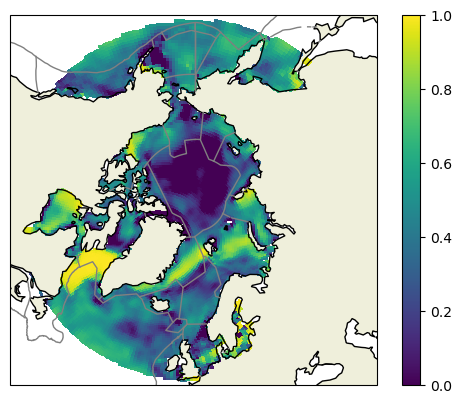

In [28]:
# a. Map PPP for each grid cell across the Arctic
t = 1
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_extent([-180, 180, 49, 90], crs = ccrs.PlateCarree());
clim_ac = ma.masked_array(clim_var[t,:,:], lat < 50)
pc = ax.pcolormesh(lon, lat, PPP_mean[t,:,:], transform=ccrs.PlateCarree(), vmin = 0, vmax = 1);
ax.coastlines();  ax.add_feature(cfeature.LAND); plt.colorbar(pc);

# b. Plot the lines of the LMEs.
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='grey',linewidth=1)

# c. Write out the figure.
#figdir = '/glade/u/home/cpayne/PredictPerfect/Figures/PPP/' + vnnam + '_mean_2010' + str(im) + '_' + str(mon) + '.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()

9. Find the average NPP by LME over the course of the year.

In [41]:
# a. Sum NPP by LME (and area by LME). Use this to calculate mean NPP for each LME. To do this, 
#    multiply NPP by 10.377 (converts from mmol m-3 cm s-1 to g C m-2 month-1. Divide by 12 (number
#    of months summed).
NPP_lme = np.zeros([21]);
for k in np.arange(0,21):
    areasum = 0
    for i in np.arange(0,384):
        for j in np.arange(0,320):
            if lme_arc[i,j] == k and np.isnan(areacello_ocn[i,j]) == False:
                NPP_lme[k] = np.nansum(clim[:,i,j])*10.377/12*areacello_ocn[i,j] + NPP_lme[k]
                areasum = areasum + areacello_ocn[i,j]
    NPP_lme[k] = NPP_lme[k] / areasum

# b. Cycle through all grid cells and assign each the average NPP for that LME.
NPP_lme2 = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(lme_arc[i,j]) == False and np.isnan(areacello_ocn[i,j]) == False:
            k = lme_arc[i,j]
            NPP_lme2[i,j] = NPP_lme[int(k)]
            

10. Plot Figure 2a - average NPP by LME.

In [55]:
# a. Plot average NPP by LME.
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());
pc = ax.pcolormesh(lon, lat, NPP_lme2, transform=ccrs.PlateCarree(), vmin = 0, vmax = .5, cmap = 'cmo.matter');
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.coastlines();  ax.add_feature(cfeature.LAND); plt.colorbar(pc);

# b. Plot the lines of the LMEs.
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='black',linewidth=1)

# c. Write out the figure.
# figdir = '/glade/u/home/cpayne/PredictPerfect/Figures/PaperFigs/LME_NPP.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()


11. Plot Figure 2b - shelf and deep Arctic and sub-Arctic regions.

In [56]:
# a. Bring in shelfmask array
dir = np.loadtxt("/glade/u/home/cpayne/PredictPerfect/Input/shelfmask.txt")
shelfmask = dir.reshape(384,320)

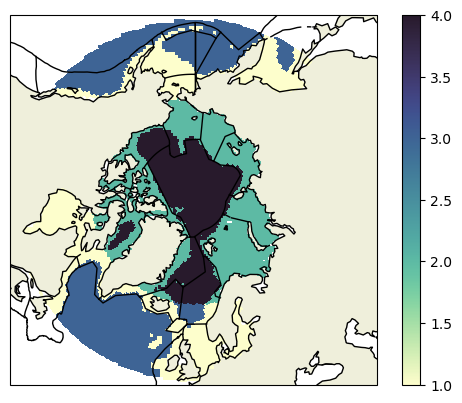

In [58]:
# b. Plot shelf and deep Arctic and sub-Arctic regions.
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_extent([-180, 180, 49, 90], crs = ccrs.PlateCarree());
pc = ax.pcolormesh(lon, lat, shelfmask, transform=ccrs.PlateCarree(), vmin = 1, vmax = 4, cmap = 'cmo.deep');
ax.coastlines();  ax.add_feature(cfeature.LAND); plt.colorbar(pc);

# c. Plot the lines of the LMEs.
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y,transform=ccrs.PlateCarree(),color='black',linewidth=1)

# d. Write out the figure.
# figdir = '/glade/u/home/cpayne/PredictPerfect/Figures/PaperFigs/shelfmask.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()